# Introduction

## Traffic Analysis in Toronto

Toronto is one of the largest and important cities in Canada. Compared to all other Canadian cities, Toronto has the largest contribution to Canada's GDP. It is also a major hub for immigration due to its vast array of options for employment and education. However with such explosive growth comes a major issue. The problem of growing traffic. Even though Toronto is a well-planned city, the traffic seems to be worsening for this city. So this has prompted me to do a an analysis on the traffic data of Toronto. This analysis could be of interest to the law enforcement of the city and the civic authorities. Using an analysis on this data they can determine in which areas they would need to upgrade the infrastructure or deploy more traffic police to better manage the tarffic.

# Data

The most important part of any analytics project is the data. The data I'm going to use in this case is from the Toronto Police Service web portal(http://data.torontopolice.on.ca/datasets/ksi/data). Using this data I can find out the areas of the cities where the most accidents take place and where the most fatal accidents take place. These areas can be brought into the focus of the concerned authorities who can take the required steps to deal with the problem. The data is in csv format and has 57 columns and 12,244 rows. Many of these columns will need to be dropped as they are not relevant to the analysis. Then some preprocessing of the data will need to be done to make it suitable for analysis. This will be used along with location data from Foursquare to draw relevant insights.

## Importing data into the Notebook

In [1]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_65f01062c1644f00a3459af4a219cac2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='dDHns2OtN8x8GU0QrWQ8FLL80tACfjLqYdRPIma0IHWb',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_65f01062c1644f00a3459af4a219cac2.get_object(Bucket='myproject-donotdelete-pr-uimu68l05sqep7',Key='KSI.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
0,-79.454730,43.675280,80771254,7001005616,2017,2017-06-03T04:00:00.000Z,2330,23,ST CLAIR AVE W,CALEDONIA RD,...,Yes,,,,13,NaN,NaN,92,NaN,12001
1,-79.520641,43.770049,80783528,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12002
2,-79.520641,43.770049,80783529,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12003
3,-79.286601,43.751868,80790062,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12004
4,-79.286601,43.751868,80790894,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12005


## Using only recent data (2013 onwards)

In [2]:
df = df[df.YEAR > 2012]

## Filtering out irrelevant data

In [3]:
df_filter = df.filter(['LATITUDE','LONGITUDE','ACCLASS', 'District','YEAR'], axis=1)
df_filter.loc[(df['ACCLASS'] ==  'Non-Fatal Injury'), 'ACCLASS'] = 0
df_filter.loc[(df['ACCLASS'] ==  'Fatal'), 'ACCLASS'] = 1
df_filter = df_filter[df_filter.District != ' ']
df_filter.head()

,LATITUDE,LONGITUDE,ACCLASS,District,YEAR
0,43.675280,-79.454730,0,Toronto and East York,2017
1,43.770049,-79.520641,0,Etobicoke York,2017
2,43.770049,-79.520641,0,Etobicoke York,2017
3,43.751868,-79.286601,1,Scarborough,2017
4,43.751868,-79.286601,1,Scarborough,2017


## Getting longitude and latitude of Toronto

In [5]:
from geopy.geocoders import Nominatim

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


# Installing Folium

In [6]:
!pip install folium

     |████████████████████████████████| 92kB 13.6MB/s eta 0:00:01


## Making 2 maps of Toronto : 1st one for Fatal Accidents and 2nd for Non-Fatal Accidents

In [7]:
import folium
from folium.plugins import MarkerCluster

map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)
map_tor2 = folium.Map(location=[latitude, longitude], zoom_start=10)

df_temp1 = df_filter[df_filter['ACCLASS'] == 1]
df_temp2 = df_filter[df_filter['ACCLASS'] == 0]

locations1 = list(zip(df_temp1['LATITUDE'], df_temp1['LONGITUDE']))
locations2 = list(zip(df_temp2['LATITUDE'], df_temp2['LONGITUDE']))

clust1 = MarkerCluster(locations = locations1)
clust2 = MarkerCluster(locations = locations2)
map_tor.add_child(clust1)
map_tor2.add_child(clust2)

display(map_tor)
display(map_tor2)



## Visualization of Fatal Accident Data

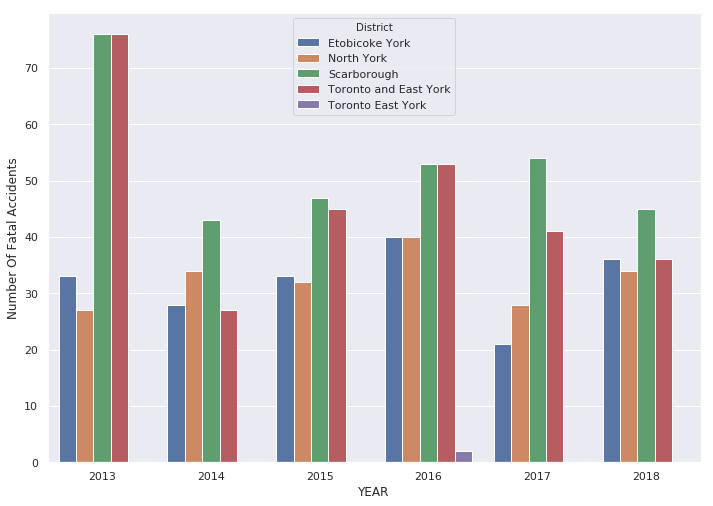

In [9]:
import seaborn as sns
df_vis1 = df_temp1.groupby(['YEAR', 'District']).count().reset_index(drop = False)
df_vis1 = df_vis1.rename(columns={"LONGITUDE": "Number Of Fatal Accidents"})
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="YEAR", y='Number Of Fatal Accidents', hue="District", data= df_vis1)

## Visualization of Non-Fatal Data

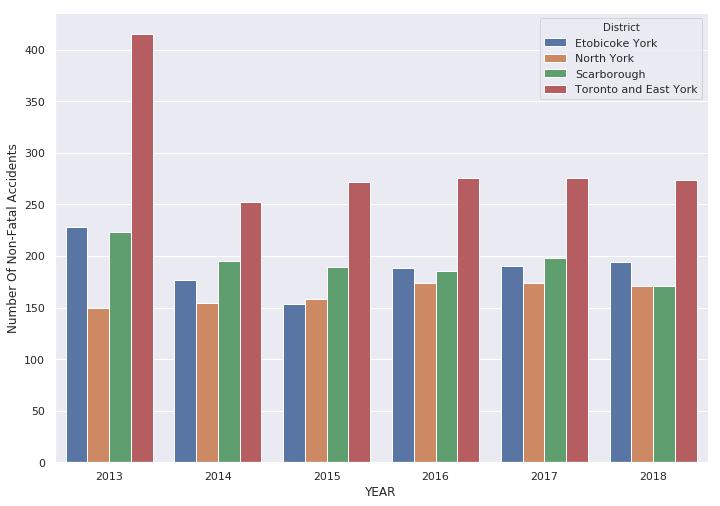

In [10]:
df_vis2 = df_temp2.groupby(['YEAR', 'District']).count().reset_index(drop = False)
df_vis2 = df_vis2.rename(columns={"LONGITUDE": "Number Of Non-Fatal Accidents"})
ax1 = sns.barplot(x="YEAR", y='Number Of Non-Fatal Accidents', hue="District", data= df_vis2)